<div>
  <center>
  <img src="https://drive.google.com/uc?id=1IHXf1W23kjHNsPR4pt61pWa0-43R7BL1" width="400"/>
  </center>
</div>

**Agarwal V, Shendure J**. [Predicting mRNA abundance directly from genomic sequence using deep convolutional neural networks](https://doi.org/10.1101/416685). 2020. *Cell Reports*. [*Github*](https://github.com/vagarwal87/Xpresso). [*Website*](https://xpresso.gs.washington.edu).

In [ ]:
import os
from typing import Dict, List, Tuple

import pandas as pd
import numpy as np
import numpy.typing as npt
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model

# Setup Xpresso dependencies, datasets, and imports


In [ ]:
INVALID_SEQUENCE_NUCLOTIDES_ERROR = "Invalid nucleotides in sequence."
INVALID_SEQUENCE_EMPTY_ERROR = "Empty sequence."
SEQUENCE_INDEX = {"A": 0, "C": 1, "G": 2, "T": 3, "a": 0, "c": 1, "g": 2, "t": 3}

In [1]:
def valid_sequence(sequence_list: List[str]) -> bool:
    """
    Check if a list of sequences is valid.

    Parameters
    ----------
    sequence_list: List[str]
        A list of sequences, where each sequence is a string of nucleotides (e.g. 'ACGT').

    Returns
    -------
    bool
        True if all sequences are valid, False otherwise.

    Examples
    --------
    >>> valid_sequence(['ACGT', 'ACGT'])
    True

    >>> valid_sequence(['ANGT', 'ACGT', 'ACGT', 'ACGT'])
    False

    >>> valid_sequence(['ACGT', 'ACGT', 'ACGT', 'ACGT', 'ACGT'])
    True
    """

    for sequence in sequence_list:
        for nucleotide in sequence:
            has_n_nucleotide = bool(nucleotide == "N" or nucleotide == "n")
            if nucleotide not in SEQUENCE_INDEX and not has_n_nucleotide:
                return False

    return True


def encode_sequence(sequence_list: List[str]) -> npt.NDArray[np.float32]:
    """
    Convert a list of sequences into a one-hot encoded tensor.

    Parameters
    ----------
    sequences_list: List[str]
        A list of sequences, where each sequence is a string of nucleotides (e.g. 'ACGT').

    Returns
    -------
    np.ndarray
        A 3D numpy array of shape (n_sequences, sequence_len, 4), where n_sequences is the number of sequences in the input list, and sequence_len is the length of each sequence. The last dimension has size 4 and corresponds to the one-hot encoding of the nucleotides (A, C, G, T).

    Examples
    --------
    >>> encode_sequence(['ACGT'])
    array([[[1., 0., 0., 0.],
            [0., 1., 0., 0.],
            [0., 0., 1., 0.],
            [0., 0., 0., 1.]], dtype=float32)
    """

    # Check if the input sequences contain invalid nucleotides
    if not valid_sequence(sequence_list):
        raise ValueError(INVALID_SEQUENCE_NUCLOTIDES_ERROR)
    # Check if the input sequences are empty
    if len(sequence_list) == 0:
        raise ValueError(INVALID_SEQUENCE_EMPTY_ERROR)

    # Get the number of sequences and the length of each sequence
    n_sequences = len(sequence_list)
    sequence_len = len(sequence_list[0])

    # Initialize an array of zeros
    sequence_vector = np.zeros((n_sequences, sequence_len, 4), dtype=np.float32)

    # Fill in the array with the one-hot encoding
    for i in range(n_sequences):
        sequence = sequence_list[i]

        # For each nucleotide in the sequence, set the corresponding one-hot encoding
        for j in range(len(sequence_list[i])):
            if sequence[j] in SEQUENCE_INDEX:
                sequence_vector[i, j, SEQUENCE_INDEX[sequence[j]]] = 1.0

    return sequence_vector

# Xpresso Module

In [2]:
DEFAULT_BATCH_SIZE = 64
DEFAULT_N_EPOCHS = 250
DEFAULT_SAVE_DIR = "./checkpoints"
DEFAULT_CHECKPOINT_NAME = "bestparams.keras"

In [3]:
class XPressoModel:
    def __init__(self, promoter_shape: Tuple[int], halflife_shape: Tuple[int]) -> None:
        """
        Initialize the model.

        Parameters
        ----------
        promoter_shape : Tuple[int]
            The shape of the promoter data.
        halflife_shape : Tuple[int]
            The shape of the halflife data.

        Examples
        --------
        >>> model = XPressoModel(promoter_shape=(1000, 4, ), halflife_shape=(8,))
        """

        self.promoter_shape = promoter_shape
        self.halflife_shape = halflife_shape
        self._model = self._create_model()

    def __call__(
        self, promoter: npt.NDArray[np.float32], halflife: npt.NDArray[np.float32]
    ) -> npt.NDArray[np.float32]:
        """
        Make a prediction using the Xpresso model.

        Parameters
        ----------
        promoter : npt.NDArray[np.float32]
            The promoter data.
        halflife : npt.NDArray[np.float32]
            The halflife data.

        Returns
        -------
        npt.NDArray[np.float32]
            The model's prediction.

        Examples
        --------
        >>> model = XPressoModel(promoter_shape=(1000, 4, ), halflife_shape=(8,))
        >>> promoter = np.random.rand(1, 1000, 4).astype(np.float32)
        >>> halflife = np.random.rand(1, 8).astype(np.float32)
        >>> model(promoter, halflife)
        array([0.5], dtype=float32)
        """

        return self._model.predict([promoter, halflife], batch_size=64).flatten()

    def fit(
        self,
        train_promoter: npt.NDArray[np.float32],
        train_halflife: npt.NDArray[np.float32],
        train_y: npt.NDArray[np.float32],
        valid_promoter: npt.NDArray[np.float32],
        valid_halflife: npt.NDArray[np.float32],
        valid_y: npt.NDArray[np.float32],
        batch_size: int = DEFAULT_BATCH_SIZE,
        n_epochs: int = DEFAULT_N_EPOCHS,
        save_dir: str = DEFAULT_SAVE_DIR,
    ) -> Dict[str, List[float]]:
        """
        Fit the model to the training data.

        Parameters
        ----------
        train_promoter : npt.NDArray[np.float32]
            The promoter data for the training set.
        train_halflife : npt.NDArray[np.float32]
            The halflife data for the training set.
        train_y : npt.NDArray[np.float32]
            The target data for the training set.
        valid_promoter : npt.NDArray[np.float32]
            The promoter data for the validation set, by default None.
        valid_halflife : npt.NDArray[np.float32]
            The halflife data for the validation set, by default None.
        valid_y : npt.NDArray[np.float32]
            The target data for the validation set, by default None.
        batch_size : int, optional
            The batch size to use during training, by default 64.
        n_epochs : int, optional
            The number of epochs to train for, by default 250.
        save_dir : str, optional
            The directory to save the model's best parameters, by default "./checkpoints".

        Returns
        -------
        Dict[str, List[float]]
            A dictionary containing the training and validation loss and accuracy history.

        Examples
        --------
        >>> model = XPressoModel(promoter_shape=(1000, 4, ), halflife_shape=(8,))
        >>> promoter = np.random.rand(1, 1000, 4).astype(np.float32)
        >>> halflife = np.random.rand(1, 8).astype(np.float32)
        >>> y = np.random.rand(1).astype(np.float32)
        >>> model.fit(promoter, halflife, y, promoter, halflife, y)
        {'loss': [0.5], 'val_loss': [0.5], 'mean_squared_error': [0.5], 'val_mean_squared_error': [0.5]}
        """

        save_path = os.path.join(save_dir, DEFAULT_CHECKPOINT_NAME)

        # Create a callback that saves the model's weights
        checkpoint_callback = ModelCheckpoint(
            save_path,
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            mode="min",
        )

        # Create a callback that stops the training when the validation loss stops improving
        earlystopping_callback = EarlyStopping(
            monitor="val_loss", patience=7, verbose=1, mode="min"
        )

        # Fit the model
        result = self._model.fit(
            [train_promoter, train_halflife],
            train_y,
            batch_size=int(batch_size),
            shuffle=True,
            epochs=n_epochs,
            validation_data=([valid_promoter, valid_halflife], valid_y),
            callbacks=[earlystopping_callback, checkpoint_callback],
        )

        return result.history

    def load(self, model_path: str):
        """
        Load a model from a file.

        Parameters
        ----------
        model_path : str
            The path to the model file.

        Examples
        --------
        >>> model = XPressoModel(promoter_shape=(1000, 4, ), halflife_shape=(8,))
        >>> model.load("model.keras")
        """

        self._model = load_model(model_path)

    def _create_model(self) -> Model:
        """
        Create the Xpresso model.
        """

        activationFxn = "relu"

        halflifedata = Input(shape=self.halflife_shape, name="halflife")
        input_promoter = Input(shape=self.promoter_shape, name="promoter")

        x = Conv1D(
            int(2**7),
            int(6),
            dilation_rate=int(1),
            padding="same",
            kernel_initializer="glorot_normal",
            activation=activationFxn,
        )(input_promoter)
        x = MaxPooling1D(int(30))(x)

        maxPool2 = int(10)
        x = Conv1D(
            int(2**5),
            int(9),
            dilation_rate=int(1),
            padding="same",
            kernel_initializer="glorot_normal",
            activation=activationFxn,
        )(x)
        x = MaxPooling1D(maxPool2)(x)

        x = Flatten()(x)
        x = Concatenate()([x, halflifedata])
        x = Dense(int(2**6))(x)
        x = Activation(activationFxn)(x)
        x = Dropout(0.00099)(x)

        x = Dense(int(2))(x)
        x = Activation(activationFxn)(x)
        x = Dropout(0.01546)(x)

        main_output = Dense(1)(x)
        model = Model(inputs=[input_promoter, halflifedata], outputs=[main_output])

        model.compile(
            optimizer=SGD(learning_rate=5 * 1e-4, momentum=0.9),
            loss="mean_squared_error",
            metrics=["mean_squared_error"],
        )

        return model

# Example

## Load Dataset

In [12]:
train_df = pd.read_csv("./train_thisone_clean.csv")
test_df = pd.read_csv("./test_thisone_clean.csv")
valid_df = pd.read_csv("./valid_thisone_clean.csv")

In [13]:
features = [
    "utr5_length",
    "cds_length",
    "intron_length",
    "utr3_length",
    "utr5_gc",
    "cds_gc",
    "utr3_gc",
    "orf_exon_density",
]
label = ["MPE"]

In [14]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)
valid_df.dropna(inplace=True)

train_X = train_df[features + ["SEQ"]]
train_mpe = train_df[label].to_numpy()
test_X = test_df[features + ["SEQ"]]
test_mpe = test_df[label].to_numpy()
valid_X = valid_df[features + ["SEQ"]]
valid_mpe = valid_df[label].to_numpy()

train_promoter = encode_sequence(train_X["SEQ"].to_numpy())
test_promoter = encode_sequence(test_X["SEQ"].to_numpy())
valid_promoter = encode_sequence(valid_X["SEQ"].to_numpy())

train_halflife = train_X[features].to_numpy()
test_halflife = test_X[features].to_numpy()
valid_halflife = valid_X[features].to_numpy()

In [15]:
print("=== Train ===")
print("Promoter:", train_promoter.shape)
print("Halflife:", train_halflife.shape)
print("MPE: ", train_mpe.shape)

print("=== Test ===")
print("Promoter:", test_promoter.shape)
print("Halflife:", test_halflife.shape)
print("MPE: ", test_mpe.shape)

print("=== Valid ===")
print("Promoter:", valid_promoter.shape)
print("Halflife:", valid_halflife.shape)
print("MPE: ", valid_mpe.shape)

=== Train ===
Promoter: (13714, 20000, 4)
Halflife: (13714, 8)
MPE:  (13714, 1)
=== Test ===
Promoter: (816, 20000, 4)
Halflife: (816, 8)
MPE:  (816, 1)
=== Valid ===
Promoter: (829, 20000, 4)
Halflife: (829, 8)
MPE:  (829, 1)


## Traning & Testing

In [10]:
# Load the model with specific input shape
model = XPressoModel(
    promoter_shape=valid_promoter.shape[1:], halflife_shape=valid_halflife.shape[1:]
)

# Train the model using training and validation set
result = model.fit(
    valid_promoter,
    valid_halflife,
    valid_mpe,
    valid_promoter,
    valid_halflife,
    valid_mpe,
    n_epochs=20,
)

prediction = model(test_promoter, test_halflife)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - loss: 0.2605 - mean_squared_error: 0.2605
Epoch 1: val_loss improved from inf to 0.24475, saving model to ./checkpoints/bestparams.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 512ms/step - loss: 0.2599 - mean_squared_error: 0.2599 - val_loss: 0.2448 - val_mean_squared_error: 0.2448
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2400 - mean_squared_error: 0.2400
Epoch 2: val_loss did not improve from 0.24475
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - loss: 0.2403 - mean_squared_error: 0.2403 - val_loss: 0.2462 - val_mean_squared_error: 0.2462
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.2484 - mean_squared_error: 0.2484
Epoch 3: val_loss improved from 0.24475 to 0.23845, saving model to ./checkpoints/bestparams.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - loss: 0.2486 - mean_squared_error: 0.2486 - val_loss: 0.2384 - val_mean_squared_error: 0.2384
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 

## Evaluation

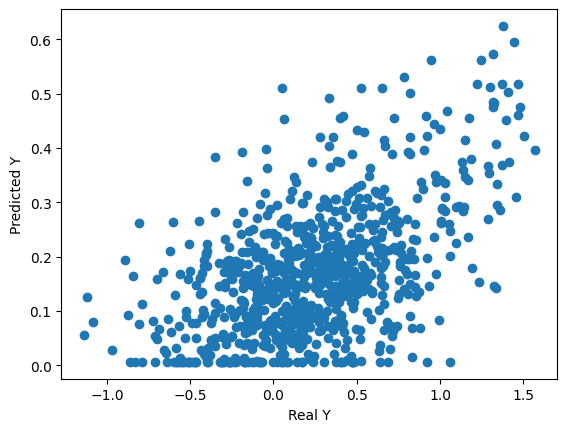

In [11]:
import matplotlib.pyplot as plt

plt.scatter(test_mpe, prediction)
plt.xlabel("Real Y")
plt.ylabel("Predicted Y")
plt.show()